In [17]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display
import librosa
import zipfile
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from google.colab import drive
drive.mount('/content/drive')



# FILEPATH: /Users/kmpandey/Desktop/3-2/Deep Learning/Project/Notebooks/Project_1 (1).ipyn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract files from zip folder [ONLY EXECUTE ONCE]

In [ ]:
# Path to the zip file
zip_file_path = '/content/drive/My Drive/audio_dataset.zip'

# Directory to extract the contents
extract_dir = '/content/drive/My Drive/audio_dataset'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

Get all class names

In [2]:
data_dir = '/content/drive/My Drive/audio_dataset/audio_dataset/train'
classes = os.listdir(data_dir)

View info about duration of clips

In [3]:
def print_duration_info(data):
    duration_df = pd.DataFrame(columns=['Duration'])

    # Iterate over each waveform in the list and get its duration
    for i, waveform in enumerate(train_data):
        duration = librosa.get_duration(y=waveform)
        duration_df.loc[i] = duration

    # Use .describe() to get summary statistics
    summary_stats = duration_df.describe()

    print(summary_stats)

Functions for loading data & create mel spectograms, displaying audio

In [20]:
def load_audio(file_path):
  waveform, sample_rate = librosa.load(file_path, sr=None)
  waveform, index = librosa.effects.trim(waveform, top_db=60)

    # pad to a length of 4s
  if len(waveform) > hyper_params['duration']:
      waveform = waveform[:hyper_params['duration']]
  else:
      padding = hyper_params['duration'] - len(waveform)
      offset = padding // 2
      waveform = np.pad(waveform, (offset, hyper_params['duration'] - len(waveform) - offset), 'constant')

  return waveform, sample_rate

def create_melspec(params, audio_data, sampling_rate):
  S = librosa.feature.melspectrogram(y = audio_data,
                                       sr=sampling_rate,
                                       n_mels=params['n_mels'],
                                       hop_length=params['hop_length'],
                                       n_fft=params['n_fft'],
                                       fmin=params['fmin'],
                                       fmax=(sampling_rate // 2))
  Sb = librosa.power_to_db(S, ref=np.max)
  Sb = Sb.astype(np.float32)

  return Sb

def load_data(data_dir):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                waveform, sample_rate = load_audio(file_path)
                mel_spec = create_melspec(hyper_params, waveform, sample_rate)
                data.append(mel_spec)
                labels.append(class_name)

    return data, labels

def display_audio(audio_file_path):
  waveform, sample_rate = librosa.load(audio_file_path, sr=None)

  # Plot the waveform
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(waveform, sr=sample_rate)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title('Waveform of Audio File')
  plt.show()

def display_spec(mel_spec):
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spec, x_axis='off', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.show()

Model Architecture

In [5]:
class CNNModel1(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5, stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 5, stride = 1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.lin1 = nn.Linear(in_features= 4*4*10,out_features = 100)
    self.lin2 = nn.Linear(100,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [7]:
def get_accuracy(predictions, targets):
  length = len(predictions)
  correct = 0
  for idx in range(length):
    if predictions[idx] == targets[idx]: correct +=1

  return (correct/length) * 100

In [8]:
def train_epoch_1(model, train_x, train_y, validation_x, validation_y):

  epoch_loss = 0

  model.train()
  train_preds = list()
  train_targets = list()


    # Train one epoch
  for batch_idx in range(num_batches_per_train_epoch):
    optimizer.zero_grad()  # This line is necessary to flush out the gradients of the previous batch.

    input = train_x[batch_idx*batch_size: (batch_idx+1)*batch_size] # Slice out batch_size amount of the training data
    output = model(input)
    target_out = train_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    preds = torch.argmax(output, dim=1)

    train_preds +=(list(preds.detach().cpu().numpy()))
    train_targets+=(list(target_out.detach().cpu().numpy()))
    batch_loss = criterion(output, target_out)

    batch_loss.backward()
    optimizer.step()
    epoch_loss += batch_loss
  epoch_loss_ret = epoch_loss.detach().cpu() / batch_size

    # Switch model to eval mode since we do not want to update our weights using test/val set images! They are for measuring performance only
  model.eval()
    # Training Performance at the end of epoch

  val_preds = list()
  val_targets = list()

  for batch_idx in range(num_batches_validation):
    input = validation_x[batch_idx*batch_size: (batch_idx+1)*batch_size]
    output = model(input)
    target_out = validation_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    # preds = torch.argmax(output, dim=1)
    preds = torch.max(output, 1)[1]


    val_preds += (list(preds.detach().cpu().numpy()))
    val_targets+=(list(target_out.detach().cpu().numpy()))

  train_accuracy = get_accuracy(train_preds, train_targets)
  val_accuracy = get_accuracy(val_preds, val_targets)

  return train_accuracy, val_accuracy, epoch_loss_ret

def train_model(train_x, train_y, validation_x, validation_y, model, num_epochs):
    # Train the model
  epoch_loss = 0
  losses_at_each_epoch = list()
  train_accuracies = list()
  validation_accuracies = list()

  # Forward pass -> Backward pass -> Weight update

  for epoch in range(num_epochs):
    train_accuracy, val_accuracy, epoch_loss = train_epoch(model, train_x, train_y, validation_x, validation_y)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    losses_at_each_epoch.append(epoch_loss)

    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch, losses_at_each_epoch[-1], train_accuracies[-1], validation_accuracies[-1]))

  return model, epoch_loss, losses_at_each_epoch, train_accuracies, validation_accuracies

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [10]:
# RESNETS:
class BasicBlock(nn.Module):

  expansion=1 # expansion is 1 as there is no expansion factor is basic block

  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):

    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False) # 3x3 Conv Layer
    self.bn1 = nn.BatchNorm2d(num_features = out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    self.downsample = downsample

  def forward(self, x):

    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.downsample is not None:
      identity = self.downsample(x)

    x += identity

    return (self.relu(x))


class BottleNeckBlock(nn.Module):

  expansion = 4

  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):

    super().__init__()

    base_width = 64

    width = int(out_channels * (base_width / 64.)) * 1

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=width, kernel_size=1, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=width)
    self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features = width)
    self.conv3 = nn.Conv2d(in_channels=width, out_channels=width * self.expansion , kernel_size=1, stride=stride, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(num_features = width * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):

    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    if self.downsample is not None:
      identity = self.downsample(x)
    x+= identity

    return (self.relu(x))

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out

class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes):

    super().__init__()

    self.in_channels = 64

    # resnet stem
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features = self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #res-blocks
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    #classifier block
    self.adppool = nn.AdaptiveAvgPool2d((2,2))
    self.classifier = nn.Linear(in_features=512 * block.expansion, out_features = num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):

    downsample = None

    if stride!=1 or self.in_channels != out_channels * block.expansion:

      downsample = nn.Sequential(
          nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(num_features=out_channels * block.expansion)
    )

    layers=[]

    layers.append(block(self.in_channels, out_channels, stride, downsample))

    self.in_channels = out_channels * block.expansion

    for i in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)



  def forward(self, x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.adppool(x)
    x = torch.flatten(x, 1)

    return self.classifier(x)


class ExtendedResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 3)
        self.layer2 = self.make_layer(64, 128, 4, stride=2)
        self.layer3 = self.make_layer(128, 256, 6, stride=2)
        self.layer4 = self.make_layer(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Hyperparameters for creation of mel spectograms & model training

In [11]:
# HYPERPARAMETERS
duration_seconds = 4
sample_rate = 22050
hyper_params = {
    'duration': duration_seconds*sample_rate,
     'n_mels': 128,
    'hop_length': 512,
    'n_fft': 2048,
    'fmin': 20
}

model_params = {
    'num_epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.001,
    'num_clases': 10,
    'eta_min': 1e-5,
    't_max': 10,
    'num_workers': 0
}

Load The Data

In [14]:

#GET WAVEFORMS IN A LIST
train_data, train_labels = load_data('/content/drive/My Drive/audio_dataset/audio_dataset/train')

#GET [VAL] WAVEFORMS IN A LIST
val_data, val_labels = load_data('/content/drive/My Drive/audio_dataset/audio_dataset/val')



/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
<ipython-input-13-82a6bf5a5be2>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

AttributeError: 'list' object has no attribute 'reshape'

In [25]:
train_tensor = torch.tensor(train_data)
val_tensor = torch.tensor(val_data)

In [27]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
onehot_encoder = OneHotEncoder(sparse=False)
train_labels_onehot = onehot_encoder.fit_transform(train_labels_encoded.reshape(-1, 1))

# One-hot encode val_labels using the same mapping
val_labels_encoded = label_encoder.transform(val_labels)
val_labels_onehot = onehot_encoder.transform(val_labels_encoded.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
onehot_encoder.categories_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]

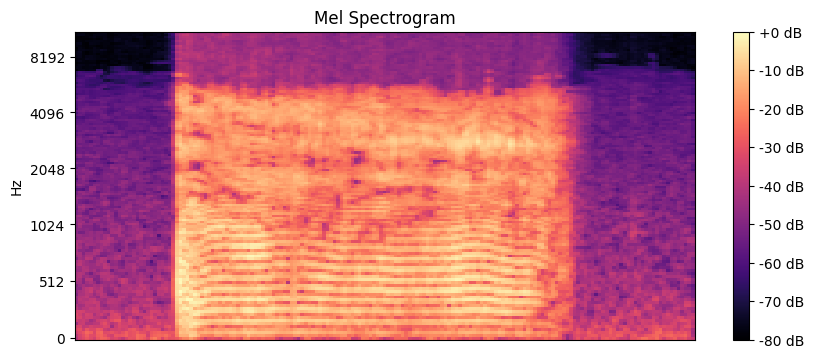

In [29]:
display_spec(train_data[0])

In [ ]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=model_params["batch_size"], num_workers=model_params["num_workers"])
val_loader = torch.utils.data.DataLoader(val_data, batch_size=model_params["batch_size"], num_workers=model_params["num_workers"])

Initialise optimizer, loss and model [Use Adam instead]

In [ ]:
model1 = Classifier()
optimizer = optim.SGD(model1.parameters(), lr = model_params["learning_rate"])
criterion = nn.CrossEntropyLoss()

Add extra dimension for batch size

In [ ]:
train_x = train_data.unsqueeze(1)
validation_x = val_data.unsqueeze(1)